In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Load data

In [194]:
data_folder = '../projet/Data/'
data_imdb = pd.read_csv(data_folder+'IMDb_data.csv')
data_bechdel = pd.read_csv(data_folder+'whole_data.csv')
data_character = pd.read_csv(data_folder+'character_metadata.csv')
data_original = pd.read_csv(data_folder+'original_movie_data.csv')

data_imdb = data_imdb.rename(columns={'Freebase_ID': 'Movie_ID'})

In [195]:
data_character.shape

(450669, 13)

Adding the rating we go from 81 741 movies to 46 737 movies (lost 35 004 movies so 43%)

In [196]:
data_original.head()

,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [197]:
data_character.head()

,Wiki_ID,Movie_ID,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie_released,character/actor_ID,character_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [198]:
#release date given either in YYYY-MM-DD or YYYY so we extract the year release such
data_original['Year'] = data_original['release_date'].astype(str).str[:4]
data_original['Year'] = pd.to_numeric(data_original['Year'], errors='coerce').astype('Int64')
print(data_original['Year'].isna().sum(), data_original['release_date'].isna().sum())

6902 6902


## Proportion of female vs male actors

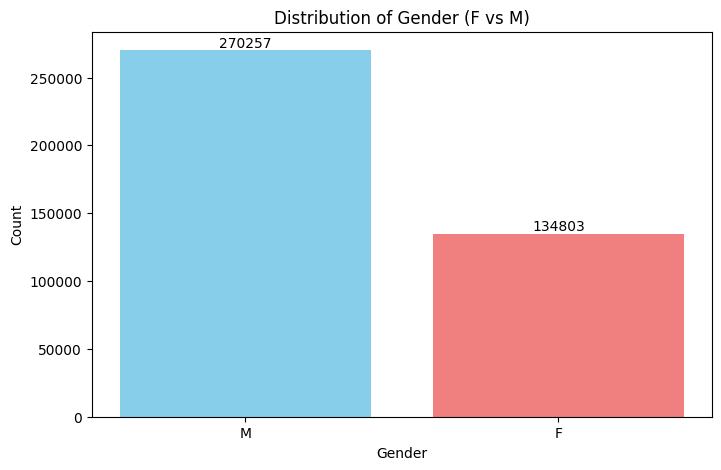

Over the 450669 total number of characters there are 134803 women. It represents 33.24 % of the characters.


In [199]:
# Assuming 'gender' is the column with 'F' and 'M' values
gender_counts = data_character['actor_gender'].value_counts()

# Plot the distribution of gender
plt.figure(figsize=(8, 5))
bars = plt.bar(gender_counts.index, gender_counts.values, color=['skyblue', 'lightcoral'])

# Add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, int(yval), ha='center', va='bottom')

# Set plot labels and title
plt.title('Distribution of Gender (F vs M)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print(f"Over the {data_character.shape[0]} total number of characters there are {gender_counts['F']} women.",
      f"It represents {100-((data_character.shape[0]-gender_counts['M'])/gender_counts['M']*100):,.4g} % of the characters.")

### Analyze Age

Check if there are incorrect values of age and replace with nan value

In [200]:
wrong_values = data_character[
    (data_character['actor_age_movie_released'] <= 5) |
    (data_character['actor_age_movie_released'] >= 90)
]

data_character.loc[wrong_values.index, 'actor_age_movie_released'] = pd.NA

print(f"There are {wrong_values.shape[0]} actors with invalid ages (<= 0 or >= 90). These have been replaced with NaNs.")


There are 1086 actors with invalid ages (<= 0 or >= 90). These have been replaced with NaNs.


In [201]:
wrong_values.head()

,Wiki_ID,Movie_ID,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie_released,character/actor_ID,character_ID,Actor_ID
156,27611999,/m/04j284s,1984,Detective Phillip Delroy,1982-02-24,M,1.55,NaN,Kevin O'Connor,1.0,/m/0cg3krb,/m/0g4n1b5,/m/07gm7s
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
2720,18241669,/m/05m__6g,1999,5 Year Old Kid,1993-10-08,M,1.75,NaN,Angus T. Jones,5.0,/m/0h2c432,/m/0h2c434,/m/09gn5h
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv


In [202]:
print(f"There are {data_original['Year'].isna().sum()} missing values in realised year in metadata of movies")
print(f"There are {data_character['release_date'].isna().sum()} missing values in realised year in character dataframe")
print(f"There are {data_character['actor_birth_date'].isna().sum()} missing values in actor birth date year in characters dataframe")

There are 6902 missing values in realised year in metadata of movies
There are 9995 missing values in realised year in character dataframe
There are 106145 missing values in actor birth date year in characters dataframe


Adds release year:

In [203]:
merged_df = pd.merge(data_character, data_original[['Movie_ID', 'Year']], on='Movie_ID', suffixes=('_women', '_imdb'), how='left')
data_character['release_year'] = merged_df['Year']
data_character['birth_year'] = data_character['actor_birth_date'].astype(str).str[:4]
data_character['birth_year'] = pd.to_numeric(data_character['birth_year'], errors='coerce').astype('Int64')

In [204]:
print(f"Missing values before process: {data_character['actor_age_movie_released'].isna().sum()}")

nan_indices = data_character[data_character['actor_age_movie_released'].isna()].index
calculated_age = (data_character.loc[nan_indices, 'release_year'] - data_character.loc[nan_indices, 'birth_year']).astype(float)
data_character.loc[nan_indices, 'actor_age_movie_released'] = calculated_age

print(f"Missing values after process: {data_character['actor_age_movie_released'].isna().sum()}")

Missing values before process: 159199
Missing values after process: 115255


In [205]:
data_character.loc[767]

Wiki_ID                          15007384
Movie_ID                       /m/03h4h5p
release_date                   1934-05-02
character_name                        NaN
actor_birth_date               1963-11-07
actor_gender                          NaN
actor_height                          NaN
actor_ethnicity                       NaN
actor_name                  Franck Dubosc
actor_age_movie_released            -29.0
character/actor_ID             /m/0bwb9k3
character_ID                          NaN
Actor_ID                       /m/01wlly9
release_year                         1934
birth_year                           1963
Name: 767, dtype: object

Some actors are associated with wrong movie! Ex with Franck Dubosc associated with "Le grand jeu" in which he never played and which was released before his birth.

There is no way to know when it it the case in general but we can still remove every characters for which the birth year of the actor is smaller than the release year of the movie.

In [206]:
valid_data = data_character['actor_age_movie_released'].dropna()
wrong_values = valid_data[(data_character['actor_age_movie_released'] <=5) | 
                                (data_character['actor_age_movie_released'] >=90)]
wrong_values = wrong_values.reset_index()
wrong_values.columns = ['ID', 'actor_age_movie_released']

data_character.drop(wrong_values['ID'], axis=0, inplace=True)
#Replace 
print(f'There are {wrong_values.shape[0]} actors with negative or 0 age when movie released. They have been deleted')
print(data_character.shape)

There are 1072 actors with negative or 0 age when movie released. They have been deleted
(449597, 15)


### Select only woman actress

In [207]:
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()
      

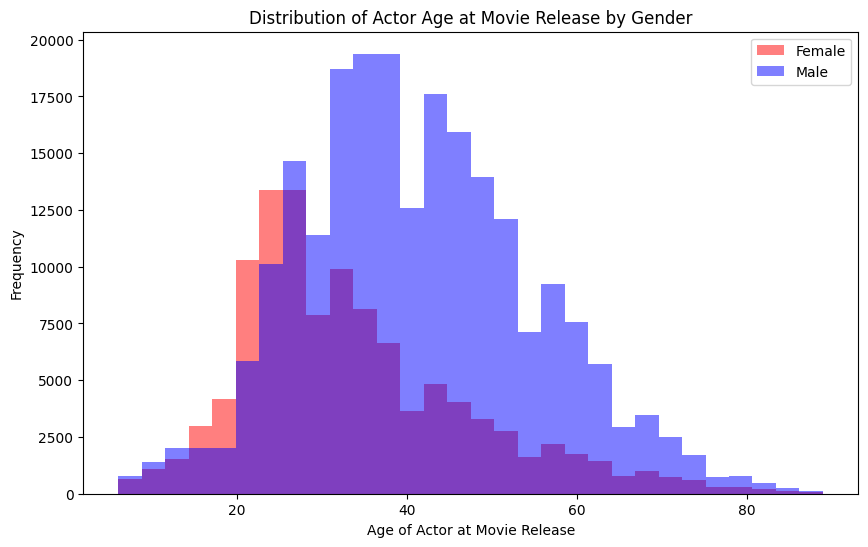

In [208]:
import matplotlib.pyplot as plt

# Separate the ages by gender
female_ages = data_character[data_character['actor_gender'] == 'F']['actor_age_movie_released'].dropna()
male_ages = data_character[data_character['actor_gender'] == 'M']['actor_age_movie_released'].dropna()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms for both genders
plt.hist(female_ages, bins=30, alpha=0.5, label='Female', color='red')
plt.hist(male_ages, bins=30, alpha=0.5, label='Male', color='blue')

# Add labels and title
plt.xlabel('Age of Actor at Movie Release')
plt.ylabel('Frequency')
plt.title('Distribution of Actor Age at Movie Release by Gender')

# Add legend
plt.legend()

# Show the plot
plt.show()


/var/folders/yc/lz46krrd2mj9d_tjm637grg40000gn/T/ipykernel_37497/1076488913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


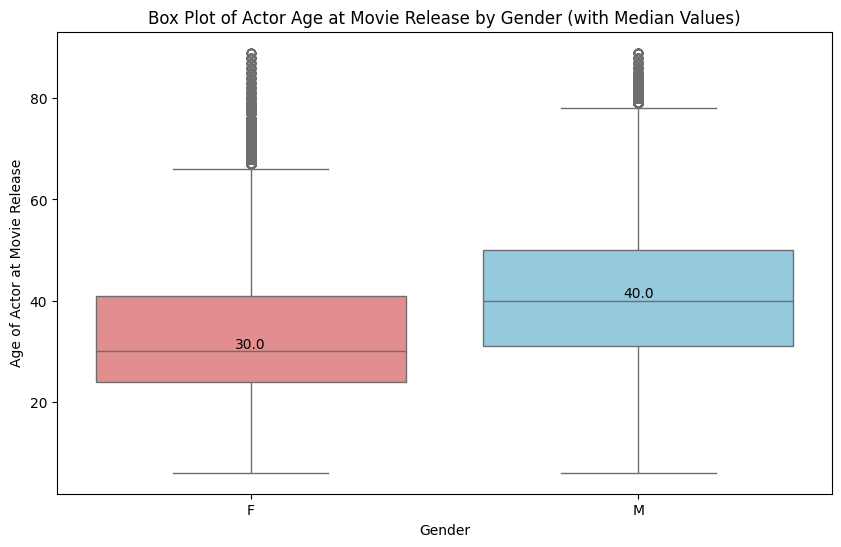

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors for genders
colors = {'F': 'lightcoral', 'M': 'skyblue'}

plt.figure(figsize=(10, 6))

# Create the box plot with custom colors
ax = sns.boxplot(
    data=data_character,
    x='actor_gender',
    y='actor_age_movie_released',
    palette=colors
)

# Calculate median values for each gender
median_values = data_character.groupby('actor_gender')['actor_age_movie_released'].median()

# Annotate the median values on the plot
for i, (gender, median) in enumerate(median_values.items()):
    ax.text(i, median, f'{median:.1f}', color='black', ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Age of Actor at Movie Release')
plt.title('Box Plot of Actor Age at Movie Release by Gender (with Median Values)')

# Show the plot
plt.show()


# Actors' height

In [210]:
data_character.shape

(449597, 15)

In [211]:
wrong_values = data_character[
    (data_character['actor_height'] < 0.8) |
    (data_character['actor_height'] > 2.72)
] #2 m 72 is the world's record for height: Robert Wadlow

data_character.loc[wrong_values.index, 'actor_height'] = pd.NA

print(f"There are {wrong_values.shape[0]} actors with invalid height (<= 0 or >= 90). These have been replaced with NaNs.")

There are 15 actors with invalid height (<= 0 or >= 90). These have been replaced with NaNs.


Since there are only a very small number of actors with wrong height format we will just discard them and not try to put it back to the right format

In [216]:
#To analyse height we want only one occurence per actor
unique_actors_df = data_character.drop_duplicates(subset=['Actor_ID'], keep='first').copy()
unique_actors_df.shape

(135520, 15)

/var/folders/yc/lz46krrd2mj9d_tjm637grg40000gn/T/ipykernel_37497/3818932336.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


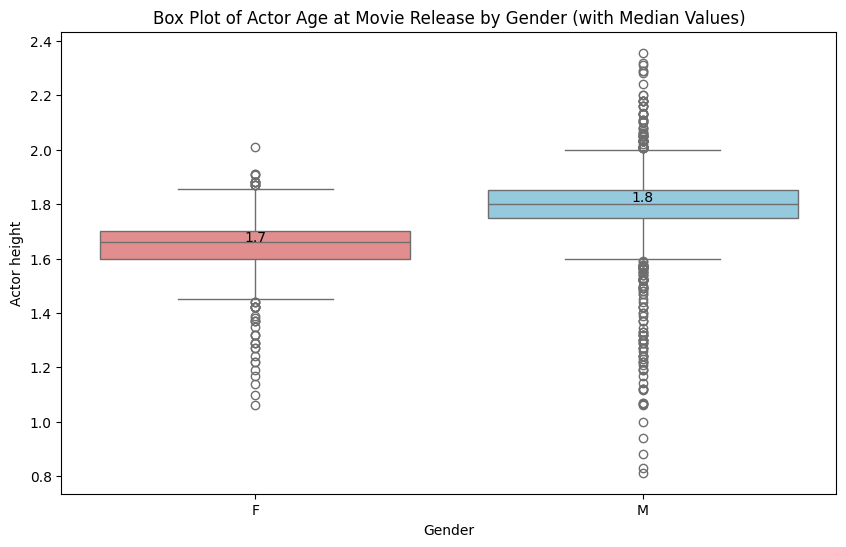

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors for genders
colors = {'F': 'lightcoral', 'M': 'skyblue'}

plt.figure(figsize=(10, 6))

# Create the box plot with custom colors
ax = sns.boxplot(
    data=unique_actors_df,
    x='actor_gender',
    y='actor_height',
    palette=colors
)

# Calculate median values for each gender
median_values = data_character.groupby('actor_gender')['actor_height'].median()

# Annotate the median values on the plot
for i, (gender, median) in enumerate(median_values.items()):
    ax.text(i, median, f'{median:.1f}', color='black', ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Actor height')
plt.title('Box Plot of Actor Age at Movie Release by Gender (with Median Values)')

# Show the plot
plt.show()
